In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#import and format data
feature_type = 'TFBS_short'
metadata_columns = ['tumor_fraction','cancer_present','sample_type','Stage']
probabilities = pd.read_csv(feature_type+'_results/probabilities.txt', sep='\t')

n_iter = 1+probabilities.drop(columns = ['sample','status']+metadata_columns).head().columns.astype(int).max()
probabilities[np.arange(n_iter)] = probabilities[[str(m)for m in np.arange(n_iter)]]
probabilities = probabilities.drop(columns = [str(m)for m in np.arange(n_iter)])
probabilities = probabilities.sort_values(by='sample_type').reset_index(drop=True)
print(n_iter)

1000


In [3]:
probabilities.head()

,sample,tumor_fraction,cancer_present,sample_type,Stage,status,0,1,2,3,...,990,991,992,993,994,995,996,997,998,999
0,Bile_Duct_Cancer_CGPLPA114,0.00000,1,Bile_Duct_Cancer,II,1,NaN,NaN,0.324939,NaN,...,NaN,NaN,NaN,0.213787,NaN,NaN,0.239864,NaN,NaN,NaN
1,Bile_Duct_Cancer_CGPLPA187,0.00000,1,Bile_Duct_Cancer,II,1,NaN,0.999967,NaN,NaN,...,NaN,0.999188,0.951264,NaN,NaN,NaN,0.988202,NaN,NaN,0.999995
2,Bile_Duct_Cancer_CGPLPA184,0.00000,1,Bile_Duct_Cancer,II,1,0.998289,NaN,NaN,0.983716,...,NaN,NaN,NaN,NaN,0.962948,1.0,0.991975,NaN,NaN,0.999995
3,Bile_Duct_Cancer_CGPLPA168,0.05498,1,Bile_Duct_Cancer,II,1,0.999153,NaN,NaN,0.999265,...,NaN,0.999999,0.989954,0.999968,0.973295,NaN,0.998898,0.998815,NaN,NaN
4,Bile_Duct_Cancer_CGPLPA165,0.02396,1,Bile_Duct_Cancer,I,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.818185,0.893045


In [4]:
#get AUC and accuracy for each bootstrap
AUCs = pd.DataFrame(columns = ['group','AUC'])
#accuracies = pd.DataFrame(columns = ['group','accuracy'])
#accuracy_per_sample = pd.DataFrame(index=probabilities.index)

for i in range(n_iter):
    if i%100==0:
        print(i)
    current = probabilities[~(probabilities[i].isnull())][['status','tumor_fraction','sample_type','Stage',i]].copy()
    #current['accuracy'] = np.where(np.round(current[i])==current['status'],1,0)
    #accuracy_per_sample[i] = current['accuracy']

    #overall accuracy and AUC
    group = 'overall'
    fpr,tpr,_ = roc_curve(current['status'],current[i])
    AUC = auc(fpr,tpr)
    AUCs = AUCs.append({'group':group, 'AUC':AUC}, ignore_index = True)

    #accuracy = current['accuracy'].mean()
    #accuracies = accuracies.append({'group':group, 'accuracy':accuracy}, ignore_index = True)

    #separate out the healthy samples to be used in every AUC
    healthy_df = current[current['sample_type']=='Healthy']
    
    for group,df in current.groupby('sample_type'):
        if group == 'Healthy' or group == 'Duodenal_Cancer':
            continue
            
        #accuracy = df['accuracy'].mean()
        #accuracies = accuracies.append({'group':group, 'accuracy':accuracy}, ignore_index = True)
        
        df2 = df.append(healthy_df, ignore_index=True)
        fpr,tpr,_ = roc_curve(df2['status'],df2[i])
        AUC = auc(fpr,tpr)
        AUCs = AUCs.append({'group':group, 'AUC':AUC}, ignore_index = True)
        
    for group,df in current.groupby('Stage'):
        if group == '0' or group == 'X':
            continue
        df2 = df.append(healthy_df, ignore_index=True)
        fpr,tpr,_ = roc_curve(df2['status'],df2[i])
        AUC = auc(fpr,tpr)
        AUCs = AUCs.append({'group':group, 'AUC':AUC}, ignore_index = True)
        
    zero_tfx = current[(current['tumor_fraction']==0) & (current['sample_type']!='Healthy')]
    low_tfx = current[(current['tumor_fraction']>0) & (current['tumor_fraction']<0.05) & (current['sample_type']!='Healthy')]
    high_tfx = current[(current['tumor_fraction']>=0.05) & (current['sample_type']!='Healthy')]
    
    for group,df in zip(['0_TFx','>0-0.05_TFx','>=0.05_TFx'],[zero_tfx,low_tfx,high_tfx]):
        df2 = df.append(healthy_df, ignore_index=True)
        fpr,tpr,_ = roc_curve(df2['status'],df2[i])
        AUC = auc(fpr,tpr)
        AUCs = AUCs.append({'group':group, 'AUC':AUC}, ignore_index = True)


0
100
200
300
400
500
600
700
800
900


In [5]:
#calculate confidence intervals
AUC_CI_df = AUCs.groupby('group').mean()
AUC_CI_df = AUC_CI_df.rename(columns = {'AUC':'mean'})

#get CI for each bootstrap
AUC_CI_df['lower'] = AUCs.groupby('group').quantile(.025)
AUC_CI_df['upper'] = AUCs.groupby('group').quantile(.975)
AUC_CI_df['metric']='AUC'

AUC_CI_df.to_csv(feature_type+'_results/CI_metrics.txt', sep='\t')
CI = AUC_CI_df.reset_index() #because I used this below

In [6]:
CI

,group,mean,lower,upper,metric
0,0_TFx,0.903068,0.849340,0.948939,AUC
1,>0-0.05_TFx,0.920414,0.858245,0.968726,AUC
2,>=0.05_TFx,0.964772,0.855499,1.000000,AUC
3,Bile_Duct_Cancer,0.946772,0.866667,0.998044,AUC
4,Breast_Cancer,0.916742,0.853050,0.969281,AUC
5,Colorectal_Cancer,0.957216,0.898857,0.998363,AUC
6,Gastric_cancer,0.885987,0.766065,0.979023,AUC
7,I,0.895717,0.813987,0.965945,AUC
8,II,0.908842,0.845182,0.953561,AUC
9,III,0.938263,0.861031,0.990014,AUC


Bile_Duct_Cancer 0.9566511627906977
Bile_Duct_Cancer 0.9467724978330649
Breast_Cancer 0.9276485788113695
Breast_Cancer 0.9167421227325596
Colorectal_Cancer 0.967269595176572
Colorectal_Cancer 0.9572164623969932
Gastric_cancer 0.8959517657192076
Gastric_cancer 0.8859866524032449
Lung_Cancer 0.9844961240310077
Lung_Cancer 0.9787467609081212
Ovarian_Cancer 0.9674418604651163
Ovarian_Cancer 0.960372011270509
Pancreatic_Cancer 0.8554035567715459
Pancreatic_Cancer 0.8406759008082254


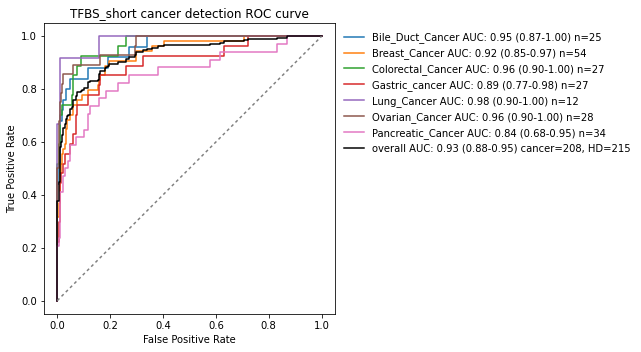

In [7]:
number_of_HD = len(probabilities[(probabilities['sample_type']=='Healthy')])
probabilities['median_probability'] = probabilities[np.arange(n_iter)].median(axis=1)

fig,ax = plt.subplots(figsize = (9.5,6))

for sample_type in probabilities['sample_type'].unique():
    if sample_type == 'Duodenal_Cancer' or sample_type == 'Healthy':#there is only one sample for Duodenal_Cancer, Healthy is included in all roc curves
        continue
    current = probabilities[(probabilities['sample_type']==sample_type) | (probabilities['sample_type']=='Healthy')]

    fpr, tpr, _ = roc_curve(current['status'].values,current['median_probability'].values)
    auc_val = auc(fpr,tpr)
    print(sample_type, auc_val)
    lower_AUC = CI[(CI['group']==sample_type) & (CI['metric']=='AUC')]['lower'].values[0]
    upper_AUC = CI[(CI['group']==sample_type) & (CI['metric']=='AUC')]['upper'].values[0]
    auc_val = CI[(CI['group']==sample_type) & (CI['metric']=='AUC')]['mean'].values[0]
    print(sample_type, auc_val)
    
    label = sample_type+' '+\
        'AUC: '+ format(auc_val,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+')'+\
        ' n='+str(len(current)-number_of_HD)
    
    ax.plot(fpr,tpr, label=label)

    
#add overall AUC
fpr, tpr, _ = roc_curve(probabilities['status'].values,probabilities['median_probability'].values)
auc_val = auc(fpr,tpr)

lower_AUC = CI[(CI['group']=='overall') & (CI['metric']=='AUC')]['lower'].values[0]
upper_AUC = CI[(CI['group']=='overall') & (CI['metric']=='AUC')]['upper'].values[0]

label = 'overall AUC: '+ format(auc_val,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+') '+\
    'cancer='+str(len(probabilities)-number_of_HD)+', HD='+str(number_of_HD)

ax.plot(fpr,tpr,color='black', label = label)

ax.legend(bbox_to_anchor = [1,1],loc = 'upper left', frameon = False)

ax.plot([0,1],[0,1], color = 'grey', dashes = (2,2))

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.set_title(feature_type+' cancer detection ROC curve')
ax.set_aspect('equal')
fig.subplots_adjust(right=.55)

plt.savefig(feature_type+'_results/'+feature_type+'_ROC_by_cancer_type.pdf')

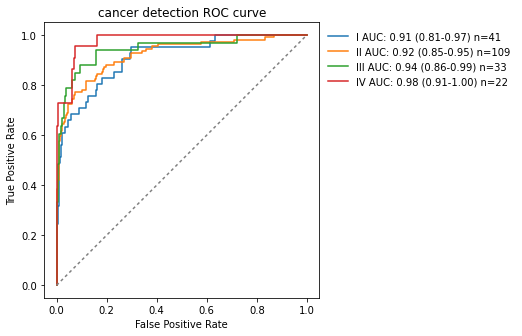

In [8]:
fig,ax = plt.subplots(figsize = (9,6))

for stage in ['I','II', 'III','IV']:
    current = probabilities[(probabilities['Stage']==stage) | (probabilities['sample_type']=='Healthy')]

    fpr, tpr, _ = roc_curve(current['status'].values,current['median_probability'].values)
    auc_val = auc(fpr,tpr)
    
    lower_AUC = CI[(CI['group']==stage) & (CI['metric']=='AUC')]['lower'].values[0]
    upper_AUC = CI[(CI['group']==stage) & (CI['metric']=='AUC')]['upper'].values[0]
    
    label = stage+' '+\
        'AUC: '+ format(auc_val,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+')'+\
        ' n='+str(len(current)-number_of_HD)

    ax.plot(fpr,tpr, label=label)
    
    
ax.legend(bbox_to_anchor = [1,1],loc = 'upper left', frameon = False)

ax.plot([0,1],[0,1], color = 'grey', dashes = (2,2))

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.set_title('cancer detection ROC curve')
ax.set_aspect('equal')
fig.subplots_adjust(right=.55)

plt.savefig(feature_type+'_results/'+feature_type+'_ROC_by_stage.pdf')

302
313
238


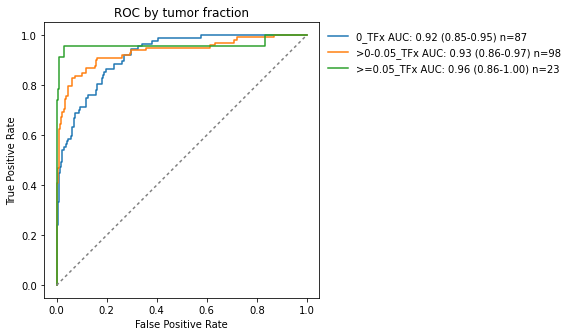

In [9]:
#plot the ROC curves 
fig,ax = plt.subplots(figsize = (9,6))

HD_samples = probabilities[probabilities['sample'].str.contains('Healthy')]

#plot zero tfx samples
current_cancer = probabilities[(probabilities['tumor_fraction']==0) & (probabilities['status']==1)]
current = current_cancer.append(HD_samples)
print(len(current))
fpr, tpr, _ = roc_curve(current['status'].values,current['median_probability'])
auc_val = auc(fpr,tpr)

group = '0_TFx'
lower_AUC = CI[(CI['group']==group) & (CI['metric']=='AUC')]['lower'].values[0]
upper_AUC = CI[(CI['group']==group) & (CI['metric']=='AUC')]['upper'].values[0]

label = group+' '+\
    'AUC: '+ format(auc_val,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+')'+\
    ' n='+str(len(current)-number_of_HD)

ax.plot(fpr,tpr, label = label)

#plot 0 to 0.05
current_cancer = probabilities[(probabilities['tumor_fraction']>0) & (probabilities['tumor_fraction']<0.05) & (probabilities['status']==1)]
current = current_cancer.append(HD_samples)
print(len(current))
fpr, tpr, _ = roc_curve(current['status'].values,current['median_probability'])
auc_val = auc(fpr,tpr)

group = '>0-0.05_TFx'
lower_AUC = CI[(CI['group']==group) & (CI['metric']=='AUC')]['lower'].values[0]
upper_AUC = CI[(CI['group']==group) & (CI['metric']=='AUC')]['upper'].values[0]

label = group+' '+\
    'AUC: '+ format(auc_val,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+')'+\
    ' n='+str(len(current)-number_of_HD)

ax.plot(fpr,tpr, label = label)

#plot 0 to 0.05
current_cancer = probabilities[(probabilities['tumor_fraction']>=0.05) & (probabilities['status']==1)]
current = current_cancer.append(HD_samples)
print(len(current))
fpr, tpr, _ = roc_curve(current['status'].values,current['median_probability'])
auc_val = auc(fpr,tpr)

group = '>=0.05_TFx'
lower_AUC = CI[(CI['group']==group) & (CI['metric']=='AUC')]['lower'].values[0]
upper_AUC = CI[(CI['group']==group) & (CI['metric']=='AUC')]['upper'].values[0]

label = group+' '+\
    'AUC: '+ format(auc_val,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+')'+\
    ' n='+str(len(current)-number_of_HD)

ax.plot(fpr,tpr, label = label)

ax.legend(bbox_to_anchor = [1,1],loc = 'upper left', frameon = False)
ax.plot([0,1],[0,1], color = 'grey', dashes = (2,2))
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC by tumor fraction')
ax.set_aspect('equal')
fig.subplots_adjust(right=.55)

plt.savefig(feature_type+'_results/'+feature_type+'_ROC_curves_by_tfx.pdf')